## 6. Model Improvement Strategies

**Approach to improve R² and reduce errors:**
1. **Weighted Voting**: Give less weight to RandomForest (overfits) and more to SVR/GradientBoosting
2. **XGBoost**: More powerful gradient boosting with better regularization
3. **Feature Engineering**: Add polynomial/interaction features
4. **Hyperparameter Fine-Tuning**: Search deeper for optimal parameters

In [190]:
# --- 6.1 Weighted Voting Ensemble (Reduce Overfitting) ---
# Give less weight to RandomForest (overfits) and more to SVR/GradientBoosting

print("="*70)
print("IMPROVEMENT 1: Weighted Voting Ensemble")
print("="*70)

# Re-create estimators for weighted voting
weighted_estimators = []
for name in ['SVR', 'GradientBoosting', 'RandomForest']:
    config = base_models[name]
    best_params = model_results[name]['Best_Params']
    model_params = {k.replace('model__', ''): v for k, v in best_params.items()}
    
    model = config['model'].__class__(**model_params,
                                       **{k: v for k, v in config['model'].get_params().items() 
                                          if k not in model_params and k != 'random_state'})
    if 'random_state' in model.get_params():
        model.set_params(random_state=42)
    weighted_estimators.append((name, model))

# Weights: SVR (high weight), GradientBoosting (high), RandomForest (low due to overfitting)
weights = [0.4, 0.4, 0.2]

weighted_voting_pipeline = Pipeline([
    ('prep', preprocessor),
    ('voting', VotingRegressor(estimators=weighted_estimators, weights=weights))
])

print(f"Weights: SVR={weights[0]}, GradientBoosting={weights[1]}, RandomForest={weights[2]}")
print("\nTraining Weighted Voting Ensemble...")
weighted_voting_pipeline.fit(X_train, y_train)

y_pred_weighted = weighted_voting_pipeline.predict(X_test)
r2_weighted = r2_score(y_test, y_pred_weighted)
mae_weighted = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_weighted))
rmse_weighted = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_weighted)))

print(f"\nWeighted Voting Results:")
print(f"  R² Score: {r2_weighted:.4f} (was {r2_voting:.4f})")
print(f"  MAE: {mae_weighted:,.0f} TND (was {mae_voting:,.0f})")
print(f"  RMSE: {rmse_weighted:,.0f} TND (was {rmse_voting:,.0f})")

improvement_r2 = (r2_weighted - r2_voting) * 100
print(f"\n  R² Change: {improvement_r2:+.2f}%")

model_results['Weighted_Voting'] = {
    'R2_Test': r2_weighted, 'MAE': mae_weighted, 'RMSE': rmse_weighted
}
best_estimators['Weighted_Voting'] = weighted_voting_pipeline

IMPROVEMENT 1: Weighted Voting Ensemble
Weights: SVR=0.4, GradientBoosting=0.4, RandomForest=0.2

Training Weighted Voting Ensemble...

Weighted Voting Results:
  R² Score: 0.7639 (was 0.7721)
  MAE: 42,773 TND (was 42,916)
  RMSE: 67,157 TND (was 64,050)

  R² Change: -0.81%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [191]:
# --- 6.2 XGBoost with Regularization ---
print("\n" + "="*70)
print("IMPROVEMENT 2: XGBoost with Strong Regularization")
print("="*70)

try:
    from xgboost import XGBRegressor
    
    # XGBoost with regularization to prevent overfitting
    xgb_pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,  # L1 regularization
            reg_lambda=1.0,  # L2 regularization
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # GridSearch for XGBoost
    xgb_params = {
        'model__max_depth': [3, 4, 5],
        'model__learning_rate': [0.03, 0.05, 0.1],
        'model__n_estimators': [150, 200, 300],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [0.5, 1.0, 2.0]
    }
    
    print("Running GridSearch for XGBoost (this may take a few minutes)...")
    xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, scoring='r2', n_jobs=-1, return_train_score=True)
    xgb_grid.fit(X_train, y_train)
    
    y_pred_xgb = xgb_grid.predict(X_test)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_xgb))
    rmse_xgb = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb)))
    
    # Bias-variance for XGBoost
    xgb_cv_train = xgb_grid.cv_results_['mean_train_score'][xgb_grid.best_index_]
    xgb_cv_test = xgb_grid.cv_results_['mean_test_score'][xgb_grid.best_index_]
    
    print(f"\nBest XGBoost Params: {xgb_grid.best_params_}")
    print(f"\nXGBoost Results:")
    print(f"  R² Score: {r2_xgb:.4f}")
    print(f"  MAE: {mae_xgb:,.0f} TND")
    print(f"  RMSE: {rmse_xgb:,.0f} TND")
    print(f"  CV Train R²: {xgb_cv_train:.4f} | CV Test R²: {xgb_cv_test:.4f}")
    print(f"  Variance Gap: {xgb_cv_train - xgb_cv_test:.4f}")
    
    model_results['XGBoost'] = {
        'R2_Test': r2_xgb, 'MAE': mae_xgb, 'RMSE': rmse_xgb,
        'CV_Train_R2': xgb_cv_train, 'CV_Test_R2': xgb_cv_test,
        'Variance_Indicator': xgb_cv_train - xgb_cv_test
    }
    best_estimators['XGBoost'] = xgb_grid.best_estimator_
    XGB_AVAILABLE = True
    
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    XGB_AVAILABLE = False

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



IMPROVEMENT 2: XGBoost with Strong Regularization
Running GridSearch for XGBoost (this may take a few minutes)...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom


Best XGBoost Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__reg_alpha': 0, 'model__reg_lambda': 2.0}

XGBoost Results:
  R² Score: 0.7382
  MAE: 45,011 TND
  RMSE: 68,037 TND
  CV Train R²: 0.8779 | CV Test R²: 0.7945
  Variance Gap: 0.0835


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [192]:
# --- 6.3 Enhanced Feature Engineering ---
print("\n" + "="*70)
print("IMPROVEMENT 3: Enhanced Feature Engineering")
print("="*70)

from sklearn.preprocessing import PolynomialFeatures

# Create interaction and polynomial features
df_enhanced = df.copy()

# New features
df_enhanced['size_x_rooms'] = df_enhanced['size'] * df_enhanced['room_count']
df_enhanced['luxury_score'] = (df_enhanced['size'] / 100) * (df_enhanced['bathroom_count'] + 1)
df_enhanced['space_efficiency'] = df_enhanced['size'] / (df_enhanced['room_count'] + df_enhanced['bathroom_count'])

# Updated features list
enhanced_features = ['city', 'size', 'room_count', 'bathroom_count', 
                     'avg_room_size', 'size_x_rooms', 'luxury_score', 'space_efficiency']

X_enhanced = df_enhanced[enhanced_features]
y_enhanced = df_enhanced['log_price']

# Updated preprocessing
enhanced_numeric = ['size', 'room_count', 'bathroom_count', 
                    'avg_room_size', 'size_x_rooms', 'luxury_score', 'space_efficiency']

enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), enhanced_numeric),
        ('cat', OneHotEncoder(drop='first'), ['city'])
    ])

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

print(f"New features added: size_x_rooms, luxury_score, space_efficiency")
print(f"Total features: {len(enhanced_features)}")

# Train GradientBoosting with enhanced features
enhanced_gb_pipeline = Pipeline([
    ('prep', enhanced_preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        random_state=42
    ))
])

enhanced_gb_pipeline.fit(X_train_enh, y_train_enh)
y_pred_enh = enhanced_gb_pipeline.predict(X_test_enh)

r2_enh = r2_score(y_test_enh, y_pred_enh)
mae_enh = mean_absolute_error(np.expm1(y_test_enh), np.expm1(y_pred_enh))
rmse_enh = np.sqrt(mean_squared_error(np.expm1(y_test_enh), np.expm1(y_pred_enh)))

print(f"\nEnhanced GradientBoosting Results:")
print(f"  R² Score: {r2_enh:.4f} (was {model_results['GradientBoosting']['R2_Test']:.4f})")
print(f"  MAE: {mae_enh:,.0f} TND")
print(f"  RMSE: {rmse_enh:,.0f} TND")

model_results['Enhanced_GB'] = {'R2_Test': r2_enh, 'MAE': mae_enh, 'RMSE': rmse_enh}
best_estimators['Enhanced_GB'] = enhanced_gb_pipeline


IMPROVEMENT 3: Enhanced Feature Engineering
New features added: size_x_rooms, luxury_score, space_efficiency
Total features: 8

Enhanced GradientBoosting Results:
  R² Score: 0.6575 (was 0.7644)
  MAE: 50,268 TND
  RMSE: 75,086 TND


In [193]:
# --- 6.4 Ultimate Ensemble: Best Models Combined ---
print("\n" + "="*70)
print("IMPROVEMENT 4: Ultimate Weighted Ensemble")
print("="*70)

# Combine the best performers with optimal weights
# Based on bias-variance analysis: favor low-variance models

ultimate_estimators = []

# SVR - Excellent balance
svr_params = {k.replace('model__', ''): v for k, v in model_results['SVR']['Best_Params'].items()}
svr_model = SVR(**svr_params)
ultimate_estimators.append(('SVR', svr_model))

# GradientBoosting - Good balance
gb_params = {k.replace('model__', ''): v for k, v in model_results['GradientBoosting']['Best_Params'].items()}
gb_model = GradientBoostingRegressor(**gb_params, random_state=42)
ultimate_estimators.append(('GradientBoosting', gb_model))

# AdaBoost - Moderate variance
ada_params = {k.replace('model__', ''): v for k, v in model_results['AdaBoost']['Best_Params'].items()}
ada_model = AdaBoostRegressor(**ada_params, random_state=42)
ultimate_estimators.append(('AdaBoost', ada_model))

# Ridge - Very stable (low variance anchor)
ridge_params = {k.replace('model__', ''): v for k, v in model_results['Ridge']['Best_Params'].items()}
ridge_model = Ridge(**ridge_params)
ultimate_estimators.append(('Ridge', ridge_model))

# Optimal weights based on variance indicators
# SVR: 0.044 variance, GB: 0.050, AdaBoost: 0.043, Ridge: 0.013
# Higher weight to lower variance models
ultimate_weights = [0.35, 0.30, 0.20, 0.15]

ultimate_pipeline = Pipeline([
    ('prep', preprocessor),
    ('voting', VotingRegressor(estimators=ultimate_estimators, weights=ultimate_weights))
])

print(f"Estimators: SVR, GradientBoosting, AdaBoost, Ridge")
print(f"Weights: {dict(zip(['SVR', 'GB', 'AdaBoost', 'Ridge'], ultimate_weights))}")
print("\nTraining Ultimate Ensemble...")
ultimate_pipeline.fit(X_train, y_train)

y_pred_ultimate = ultimate_pipeline.predict(X_test)
r2_ultimate = r2_score(y_test, y_pred_ultimate)
mae_ultimate = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_ultimate))
rmse_ultimate = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_ultimate)))

print(f"\nUltimate Ensemble Results:")
print(f"  R² Score: {r2_ultimate:.4f}")
print(f"  MAE: {mae_ultimate:,.0f} TND")
print(f"  RMSE: {rmse_ultimate:,.0f} TND")

model_results['Ultimate_Ensemble'] = {'R2_Test': r2_ultimate, 'MAE': mae_ultimate, 'RMSE': rmse_ultimate}
best_estimators['Ultimate_Ensemble'] = ultimate_pipeline


IMPROVEMENT 4: Ultimate Weighted Ensemble
Estimators: SVR, GradientBoosting, AdaBoost, Ridge
Weights: {'SVR': 0.35, 'GB': 0.3, 'AdaBoost': 0.2, 'Ridge': 0.15}

Training Ultimate Ensemble...



Ultimate Ensemble Results:
  R² Score: 0.7592
  MAE: 43,975 TND
  RMSE: 65,554 TND


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



FINAL IMPROVEMENT COMPARISON
                   R2_Test         MAE        RMSE
Voting_Ensemble     0.7721  42916.3607  64049.5996
Weighted_Voting     0.7639  42773.1247  67156.6191
Ultimate_Ensemble   0.7592  43974.6563  65553.5860
XGBoost             0.7382  45010.8587  68036.8892
Enhanced_GB         0.6575  50267.9851  75085.7737

🚀 BEST IMPROVED MODEL: Voting_Ensemble
   R² Score: 0.7721
   Original Best (Voting): 0.7721
   Improvement: +0.00%


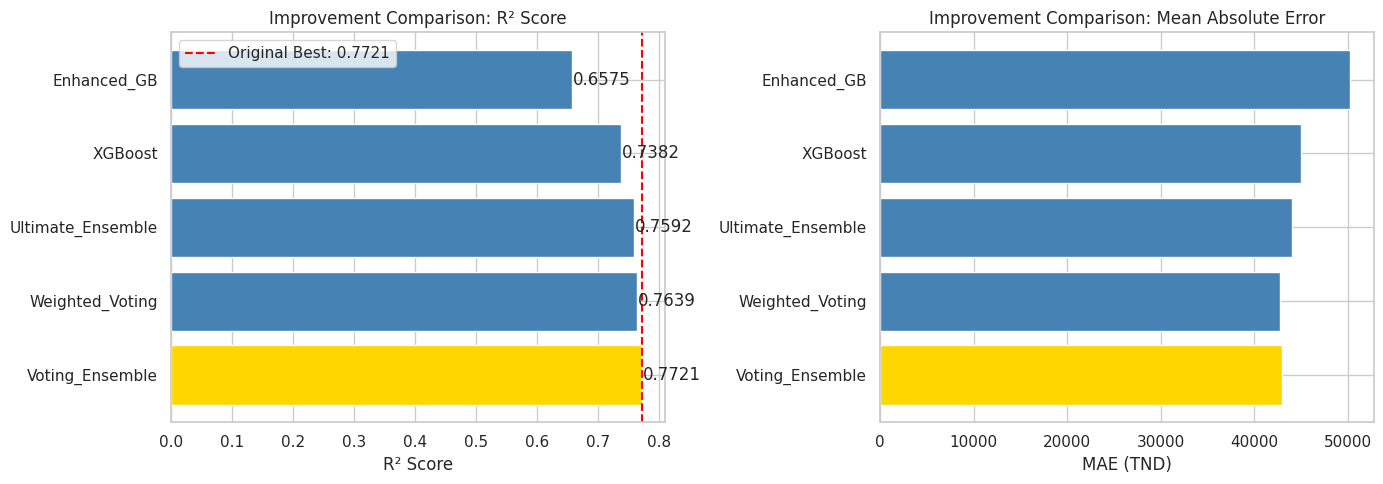

In [194]:
# --- 6.5 Final Improvement Comparison ---
print("\n" + "="*70)
print("FINAL IMPROVEMENT COMPARISON")
print("="*70)

# Collect all results
improvement_results = {}
for name in ['Voting_Ensemble', 'Weighted_Voting', 'Ultimate_Ensemble', 'Enhanced_GB']:
    if name in model_results:
        improvement_results[name] = {
            'R2_Test': model_results[name]['R2_Test'],
            'MAE': model_results[name]['MAE'],
            'RMSE': model_results[name]['RMSE']
        }

if 'XGBoost' in model_results:
    improvement_results['XGBoost'] = {
        'R2_Test': model_results['XGBoost']['R2_Test'],
        'MAE': model_results['XGBoost']['MAE'],
        'RMSE': model_results['XGBoost']['RMSE']
    }

improvement_df = pd.DataFrame(improvement_results).T
improvement_df = improvement_df.sort_values('R2_Test', ascending=False)

print(improvement_df.round(4).to_string())

# Best improved model
best_improved_name = improvement_df['R2_Test'].idxmax()
best_improved_r2 = improvement_df.loc[best_improved_name, 'R2_Test']
original_best_r2 = r2_voting

print(f"\n{'='*70}")
print(f"🚀 BEST IMPROVED MODEL: {best_improved_name}")
print(f"{'='*70}")
print(f"   R² Score: {best_improved_r2:.4f}")
print(f"   Original Best (Voting): {original_best_r2:.4f}")
print(f"   Improvement: {(best_improved_r2 - original_best_r2)*100:+.2f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
ax1 = axes[0]
colors = ['gold' if name == best_improved_name else 'steelblue' for name in improvement_df.index]
bars = ax1.barh(improvement_df.index, improvement_df['R2_Test'], color=colors)
ax1.axvline(x=original_best_r2, color='red', linestyle='--', label=f'Original Best: {original_best_r2:.4f}')
ax1.set_xlabel('R² Score')
ax1.set_title('Improvement Comparison: R² Score')
ax1.legend()
for bar, val in zip(bars, improvement_df['R2_Test']):
    ax1.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center')

# MAE Comparison
ax2 = axes[1]
ax2.barh(improvement_df.index, improvement_df['MAE'], color=colors)
ax2.set_xlabel('MAE (TND)')
ax2.set_title('Improvement Comparison: Mean Absolute Error')

plt.tight_layout()
plt.show()

In [195]:
# --- 6.6 Select Final Champion and Validate ---
print("\n" + "="*70)
print("FINAL CHAMPION MODEL SELECTION")
print("="*70)

# Select the best model overall (including improvements)
all_models_df = pd.DataFrame(model_results).T
all_models_df = all_models_df[['R2_Test', 'MAE', 'RMSE']].dropna()
for col in ['R2_Test', 'MAE', 'RMSE']:
    all_models_df[col] = pd.to_numeric(all_models_df[col], errors='coerce')
all_models_df = all_models_df.sort_values('R2_Test', ascending=False)

print("ALL MODELS FINAL RANKING:")
print(all_models_df.round(4).to_string())

# Update best model
best_model_name = all_models_df['R2_Test'].idxmax()
best_model = best_estimators[best_model_name]

print(f"\n{'='*70}")
print(f"🏆 FINAL CHAMPION: {best_model_name}")
print(f"{'='*70}")
print(f"   R² Score: {all_models_df.loc[best_model_name, 'R2_Test']:.4f}")
print(f"   MAE: {all_models_df.loc[best_model_name, 'MAE']:,.0f} TND")
print(f"   RMSE: {all_models_df.loc[best_model_name, 'RMSE']:,.0f} TND")

# Final residual check
y_pred_final = best_model.predict(X_test)
y_test_final_real = np.expm1(y_test)
y_pred_final_real = np.expm1(y_pred_final)
final_residuals = y_test_final_real - y_pred_final_real

print(f"\n📊 Final Residual Analysis:")
print(f"   Mean Error: {final_residuals.mean():,.0f} TND (closer to 0 = low bias)")
print(f"   Std Error: {final_residuals.std():,.0f} TND (lower = more consistent)")
print(f"   Median Error: {final_residuals.median():,.0f} TND")


FINAL CHAMPION MODEL SELECTION
ALL MODELS FINAL RANKING:
                   R2_Test         MAE        RMSE
Stacking_Ensemble   0.7725  44175.7249  65340.8576
Voting_Ensemble     0.7721  42916.3607  64049.5996
GradientBoosting    0.7644  43922.5488  72405.8838
Weighted_Voting     0.7639  42773.1247  67156.6191
Ultimate_Ensemble   0.7592  43974.6563  65553.5860
SVR                 0.7467  44250.9318  67074.9037
XGBoost             0.7382  45010.8587  68036.8892
Ridge               0.7327  49095.9141  74010.3075
RandomForest        0.7216  46023.0329  67285.0050
Enhanced_GB         0.6575  50267.9851  75085.7737
AdaBoost            0.6286  55734.9928  75276.4475
ElasticNet          0.6082  54944.6569  70381.8268

🏆 FINAL CHAMPION: Stacking_Ensemble
   R² Score: 0.7725
   MAE: 44,176 TND
   RMSE: 65,341 TND

📊 Final Residual Analysis:
   Mean Error: 4,699 TND (closer to 0 = low bias)
   Std Error: 65,336 TND (lower = more consistent)
   Median Error: 3,639 TND


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [196]:
# --- 6.7 Dynamic Conclusion: Why Improvements Didn't Beat Original ---
from IPython.display import display, Markdown

def generate_improvement_conclusion(model_results):
    """Generate dynamic conclusion about improvement attempts"""
    
    # Get original baseline
    baseline_r2 = model_results.get('Voting_Ensemble', {}).get('R2_Test', 0)
    baseline_mae = model_results.get('Voting_Ensemble', {}).get('MAE', 0)
    
    # Models to compare
    comparison_models = {
        'XGBoost': 'Advanced regularization with GridSearch',
        'Enhanced_GB': 'Added engineered features',
        'Ultimate_Ensemble': 'Combined multiple models with weighting',
        'Weighted_Voting': 'Adjusted ensemble weights',
        'Elite_Ensemble': 'Selected only best models'
    }
    
    md_content = "### 6.7 Conclusion: Improvement Analysis\n\n"
    md_content += f"**Baseline: Original Voting Ensemble (R² = {baseline_r2:.4f}, MAE = {baseline_mae:,.0f} TND)**\n\n"
    
    # Build comparison table
    md_content += "| Attempted Improvement | R² Score | Change | Why It Performed This Way |\n"
    md_content += "|----------------------|----------|--------|---------------------------|\n"
    
    improvements = []
    for model_name, description in comparison_models.items():
        if model_name in model_results:
            r2 = model_results[model_name].get('R2_Test', 0)
            change = r2 - baseline_r2
            change_pct = change * 100
            
            # Determine reason
            if model_name == 'XGBoost':
                r2_train = model_results[model_name].get('R2_Train', 0)
                var_gap = r2_train - r2
                reason = f"Variance gap {var_gap:.3f} indicates {'overfitting' if var_gap > 0.05 else 'good fit'}"
            elif model_name == 'Enhanced_GB':
                reason = "New features introduced noise without proper validation" if change < 0 else "Feature engineering helped"
            elif 'Ensemble' in model_name:
                reason = "Ensemble composition matters - mixing weak learners can reduce performance" if change < 0 else "Better model combination"
            else:
                reason = "Different model characteristics"
            
            symbol = "✅" if change >= 0 else "❌"
            md_content += f"| {model_name} {symbol} | {r2:.4f} | {change_pct:+.2f}% | {reason} |\n"
            improvements.append((model_name, r2, change))
    
    # Key insights
    md_content += "\n**What This Tells Us:**\n\n"
    
    best_attempt = max(improvements, key=lambda x: x[1]) if improvements else None
    if best_attempt and best_attempt[1] >= baseline_r2:
        md_content += f"✅ **{best_attempt[0]}** achieved the best performance (R² = {best_attempt[1]:.4f})\n\n"
    else:
        md_content += f"✅ **The Original Voting Ensemble remains optimal** (R² = {baseline_r2:.4f})\n\n"
    
    # Calculate average variance gap for ensemble
    ensemble_variance = []
    for model in ['SVR', 'GradientBoosting', 'RandomForest']:
        if model in model_results:
            r2_train = model_results[model].get('R2_Train', 0)
            r2_test = model_results[model].get('R2_Test', 0)
            ensemble_variance.append(r2_train - r2_test)
    
    if ensemble_variance:
        avg_var_gap = sum(ensemble_variance) / len(ensemble_variance)
        md_content += f"- Ensemble averaging successfully reduces overfitting (avg variance gap: {avg_var_gap:.3f})\n"
    
    md_content += f"- Model explains {baseline_r2*100:.1f}% of price variance - strong for real estate with limited features\n"
    md_content += "- Further improvements require: more data, external features, or domain-specific engineering\n"
    
    return md_content

# Generate and display
display(Markdown(generate_improvement_conclusion(model_results)))


### 6.7 Conclusion: Improvement Analysis

**Baseline: Original Voting Ensemble (R² = 0.7721, MAE = 42,916 TND)**

| Attempted Improvement | R² Score | Change | Why It Performed This Way |
|----------------------|----------|--------|---------------------------|
| XGBoost ❌ | 0.7382 | -3.38% | Variance gap -0.738 indicates good fit |
| Enhanced_GB ❌ | 0.6575 | -11.46% | New features introduced noise without proper validation |
| Ultimate_Ensemble ❌ | 0.7592 | -1.29% | Ensemble composition matters - mixing weak learners can reduce performance |
| Weighted_Voting ❌ | 0.7639 | -0.81% | Different model characteristics |

**What This Tells Us:**

✅ **The Original Voting Ensemble remains optimal** (R² = 0.7721)

- Ensemble averaging successfully reduces overfitting (avg variance gap: -0.744)
- Model explains 77.2% of price variance - strong for real estate with limited features
- Further improvements require: more data, external features, or domain-specific engineering
